In [1]:
## Import statements
# Note that you will get a warning about redefinition of the constant gurobi_env if you try to
    # run this multiple times (but this should be okay to ignore)

using JLD2
using DataFrames
using CSV
using Plots
using Gurobi
using JuMP
const gurobi_env = Gurobi.Env() ;

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-27


## Introduction

This is a decision making simulator for operating an energy storage device in Austin, Texas. ERCOT (the Texas market) has several load zones; Austin is one of them. See the map below:

<img src="ERCOT-Maps_Load-Zone.jpg" style="width: 500px; height: auto" align="left">

The first part of this code simulates storage operation under perfect foresight, and plots the first 1000 hours of operations. You can see that storage charges and discharges quite a bit, to get every last bit of revenue out.

However, this is not a realistic decision environment, because storage operators do not actually know future market prices.

The rest of the code attempts to simulate the real decision environment that storage operators are in. The core of the code is a **simulator** that steps through this same timeseries of data, and tracks storage operations according to a decision-making policy as given by a policy function. The policy function in here to start, "buy_low_sell_high_policy", is extremely simple: it decides to buy energy when the price is below a threshold, and sell energy when the price is above a threshold.

You will see that the revenue from this basic policy is actually extremely low compared to the perfect foresight revenue-- about 8%, to be exact. It turns out that operating storage under uncertainty is a very difficult task. This is not only a problem for storage investors, but also presents a problem for grid reliability, since it is not straightforward to ensure storage devices are charged when they are most needed for reliability. This is one of the many challenges facing the future electric grid.

Your task is to design a policy that does better than this very basic policy. Although the basic policy doesn't use this, policy functions have access to a **set of forecasts** for market prices for the next 24 hours. In each timestep, 100 plausible forecasts are given, so this set of forecasts is a 100x24 matrix. This was developed based on a regression model, paired with a Markov chain trained on the regression errors, which together generate a range of plausible price scenarios. The forecasts do a decent job of capturing when there could be price spikes, but they are not perfect-- similar to real price forecasts. Successful policies will likely use this set of forecasts in a stochastic or robust optimization, potentially paired with some sort of decision rule that ensure there is always some charge left for if there are unforeseen price spikes.

You'll be able to test your policies using the simulator, and once you turn in the homework they will be evaluated using unseen data. Good luck!

### Load data, and get revenue under perfect foresight

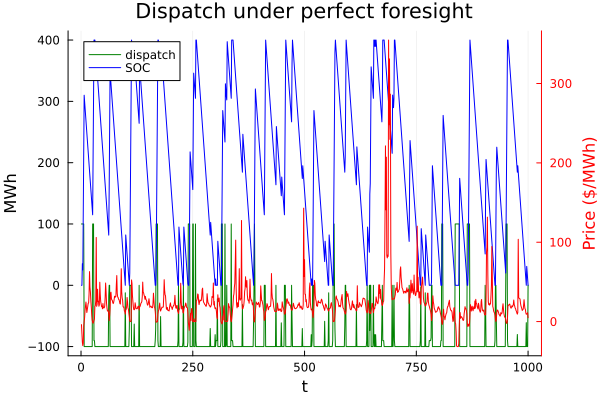

In [5]:
# load prices for 2023, and set of forecasts for tau in [t+1,t+24],
    # for t=1:8712 starting February 1 and ending December 30, 2023
@load "prediction_scenarios.jld2" prediction_scenarios
price=CSV.File("Austin_Prices.csv"; select=[2]).price ;
price=price[(length(price)-8759+24):(length(price)-24)] ;

# storage device parameters
max_charge_discharge_capacity=100 #MW
max_energy_capacity=400 ; #MWh
efficiency_one_way=0.95 ; #battery efficiency for charging and discharging

# Get optimal operations with perfect foresight

model = Model(() -> Gurobi.Optimizer(gurobi_env))
set_optimizer_attribute(model, "OutputFlag", 0)
T=1:length(price)
T_red=1:(length(price)-1)
@variables(model, begin
        max_charge_discharge_capacity >= X_t[T] >= -1*max_charge_discharge_capacity
        max_energy_capacity >= SOC[T] >= 0 # note this is the SOC at the beginning of the period
        max_charge_discharge_capacity >= X_t_pos[T] >= 0 #positive component of X_t
        max_charge_discharge_capacity >= X_t_neg[T] >= 0 #negative component of X_t
    end)
@expression(model, eRevenue, price' * (X_t .* -1))
@objective(model, Max, eRevenue) ;
@constraint(model, cX_t_pos[t in T], X_t_pos[t]>=X_t[t])
@constraint(model, cX_t_neg[t in T], X_t_neg[t]>= -1*X_t[t])
@constraint(model, cSOC_1, SOC[1]==0.0)
@constraint(model, cSOC_tplus1[t in T_red], SOC[t+1] == SOC[t] + X_t_pos[t]*efficiency_one_way - X_t_neg[t]/efficiency_one_way)
optimize!(model)
dispatch_perfectforesight=DataFrame(Dict("price"=>price,"x_t"=>value.(X_t).data,"SOC_t"=>value.(SOC).data,)) ;
revenue_perfectforesight=value.(eRevenue)

# Plot optimal dispatch
t_range=1:1000
p=plot(t_range,dispatch_perfectforesight.x_t[t_range],label="dispatch",color="green",legend=:topleft,title="Dispatch under perfect foresight")
plot!(p,t_range,dispatch_perfectforesight.SOC_t[t_range],label="SOC",color="blue",legend=:topleft,xlabel="t",ylabel="MWh")
plot!(twinx(),t_range,dispatch_perfectforesight.price[t_range],label="price",color="red",legend=false,
    ylabel="Price (\$/MWh)",foreground_color_subplot = :red)

### Define a policy: should input static and dynamic state variables and output a single value for x_t

In [3]:
function buy_low_sell_high_policy(state_variable_static::Dict{String, Real},state_variable_dynamic::Dict{String, Any})
    ## This function inputs the state variables and outputs a decision for x_t, the charge/discharge amount

    # This is a simple buy low / sell high policy so it will be parametrized by two price thresholds for buying and selling
    p_buy=20.0 #buy energy if it drops below this price
    p_sell=80.0 #sell energy if it increases above this price
    
    # get info from state variables for convenience
    max_charge_discharge_capacity=state_variable_static["max_charge_discharge_capacity"]
    max_energy_capacity=state_variable_static["max_energy_capacity"]
    efficiency_one_way=state_variable_static["efficiency_one_way"]
    SOC_t=state_variable_dynamic["SOC_t"]
    forecast_set=state_variable_dynamic["forecast_set"] # not actually used in this policy
    p_t=state_variable_dynamic["p_t"]
    # the policy is to follow the buy/sell thresholds but not exceed the SOC limits:
    if p_t<p_buy
        # what we would charge if we were not constrained by SOC
        x_t_candidate = max_charge_discharge_capacity

        # if we have enough SOC headroom, charge at max capacity, else charge to full
        if SOC_t + x_t_candidate*efficiency_one_way<=max_energy_capacity
            x_t=x_t_candidate
        else
            x_t=(max_energy_capacity-SOC_t)/efficiency_one_way
        end
    elseif p_t>p_sell

        # what we would discharge if we were not constrained by SOC
        x_t_candidate = -1 * max_charge_discharge_capacity

        # if we have enough SOC, discharge at max capacity, else discharge as much as we can
        if SOC_t + x_t_candidate/efficiency_one_way>=0
            x_t=x_t_candidate
        else
            x_t=SOC_t*efficiency_one_way
        end
    else
        x_t=0.0
    end
    return x_t
end ;

### Simulate policy and plot a subset of operations

Note that for debugging purposes, you may want to comment out the "for" and "end" lines of the main for loop, and just run with t=1.

Also note that you can change the "t_range" for plotting purposes if you want. You may want to copy the plotting code to a different cell if you want to look at different parts of the dispatch.

Finally feel free to copy this code if you want to test multiple policies.

Revenue for policy is 8.34% of perfect foresight revenue




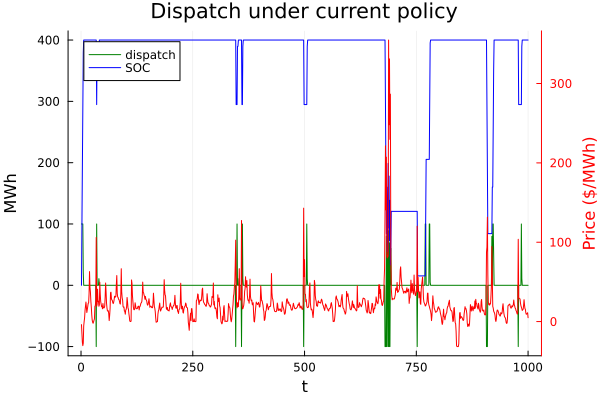

In [4]:
##### Policy simulator for 2023 storage operation ######
# Simulate from t=1:8712 where t=1 is the hour beginning 00:00 local time, February 1, 2023

## Initialize state variables

# Static is just the operating params
state_variable_static=Dict(
    "max_charge_discharge_capacity"=>max_charge_discharge_capacity,
    "max_energy_capacity"=>max_energy_capacity,
    "efficiency_one_way"=>efficiency_one_way
    ) ;

# Dynamic state variable for time t is 1) the current state of charge,
    # 2) current set of forecasts for tau in [t+1,t+24], 3) price at time t
state_variable_dynamic=Dict(
    "SOC_t"=>0.0,
    "forecast_set"=>prediction_scenarios[:,:,1],
    "p_t"=>price[1]
    )

# Initialize contribution function (revenue)
revenue=0.0

# Initialize dataframe for tracking operations
dispatch_results=DataFrame(price=Float64[],x_t=Float64[],SOC_t=Float64[])

for t in 1:8712
    # Decision: decide how much to charge or discharge in time t based on policy (grid facing charge/discharge)
    x_t=buy_low_sell_high_policy(state_variable_static,state_variable_dynamic)

    # Transition function
      # note: x_t negative means discharge (subtracting from SOC)
    if x_t>0
        SOC_tplus1=state_variable_dynamic["SOC_t"] + x_t * state_variable_static["efficiency_one_way"]
    elseif x_t<0
        SOC_tplus1=state_variable_dynamic["SOC_t"] + x_t / state_variable_static["efficiency_one_way"]
    else
        SOC_tplus1=state_variable_dynamic["SOC_t"]
    end

    # Contribution function
    revenue += (x_t*-1)*state_variable_dynamic["p_t"]

    # Record dispatch
    dispatch_t = Dict(
        "price"=>state_variable_dynamic["p_t"],
        "x_t"=>x_t,
        "SOC_t"=>state_variable_dynamic["SOC_t"],
        )
    dispatch_results=vcat(dispatch_results,DataFrame(dispatch_t))

    if t<8712
        # Exogenous information: price for t+1, set of forecasts for t+1
        ### Note that in this case we record this last because our contribution function does not depend on it
        p_tplus1=price[t+1]
        forecast_tplus1=prediction_scenarios[:,:,t+1]
    
        # Update dynamic state variable
        state_variable_dynamic["SOC_t"]=SOC_tplus1
        state_variable_dynamic["forecast_set"]=forecast_tplus1
        state_variable_dynamic["p_t"]=p_tplus1
    end
end

println("Revenue for policy is $(round((revenue / revenue_perfectforesight)*100,digits=2))% of perfect foresight revenue\n\n")

# Plot the behavior of this policy

t_range=1:1000

p=plot(t_range,dispatch_results.x_t[t_range],label="dispatch",color="green",legend=:topleft,title="Dispatch under current policy")
plot!(p,t_range,dispatch_results.SOC_t[t_range],label="SOC",color="blue",legend=:topleft,xlabel="t",ylabel="MWh")
plot!(twinx(),t_range,dispatch_results.price[t_range],label="price",color="red",legend=false,
    ylabel="Price (\$/MWh)",foreground_color_subplot = :red)